## Agrupar clientes en una ciudad mediante K-means

Utilizando el módulo KMeans de scikit-learn

Referencias:
- El algoritmo k-means aplicado a clasificación y procesamiento de imágenes

Computación Numerica - Universidad de Oviedo - Departamento de Matemáticas.
https://www.unioviedo.es/compnum/laboratorios_py/kmeans/kmeans.html

- Definitive Guide to K-Means Clustering with Scikit-Learn

Cássia Sampaio - StackAbuse.
https://stackabuse.com/k-means-clustering-with-scikit-learn/

- Best Practices Using Geocoding API Web Services

https://developers.google.com/maps/documentation/geocoding/web-service-best-practices?hl=en

- Easy Steps To Plot Geographic Data on a Map — Python

Ahmed Quassim - Towards Data Science
https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db
https://medium.com/@abuqassim115/thanks-for-your-response-frank-fb869824ede2

In [69]:
import openpyxl
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import urllib.request
import urllib.parse
import os

%matplotlib inline
plt.style.use('ggplot')

In [70]:
print(f'The scikit-learn version is {sklearn.__version__}')

The scikit-learn version is 1.1.2


In [71]:
arch = 'Nómina de Clientes'
clientes = pd.read_excel(f'./{arch}.xlsx', index_col=0,
                         na_values=[" "],
                         dtype={'cod_cliente': str, 'razon_social': str, 'domicilio': str, 'ciudad': str, 'cod_postal': str, 'provincia': str},
                         usecols=['cod_cliente', 'razon_social', 'domicilio', 'ciudad', 'cod_postal', 'provincia'])
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
010001,CLIENTE EJEMPLO 1,SAN LORENZO 52,Gaiman,9105,Chubut
010002,CLIENTE EJEMPLO 2,28 DE JULIO 641,Gaiman,9105,Chubut
010003,CLIENTE EJEMPLO 3,BROWN 928,Gaiman,9105,Chubut
010004,CLIENTE EJEMPLO 4,TELLO 643,Gaiman,9105,Chubut
010005,CLIENTE EJEMPLO 5,COM. ESPORA 21,Gaiman,9105,Chubut


Para el análisis a desarrollar decidí eliminar las filas que no contenían datos, ya que sería inútil tratar de conseguir las coordenadas de una dirección inexistente o ubicar un cliente que no sabemos quién es ya que no tiene sus datos completos, además de que para la presente demostración no es tan relevante. De ser necesario se podría requerir a la fuerza de ventas que complete los datos antes de hacer el análisis. 

In [72]:
clientes.dropna(inplace=True)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
010001,CLIENTE EJEMPLO 1,SAN LORENZO 52,Gaiman,9105,Chubut
010002,CLIENTE EJEMPLO 2,28 DE JULIO 641,Gaiman,9105,Chubut
010003,CLIENTE EJEMPLO 3,BROWN 928,Gaiman,9105,Chubut
010004,CLIENTE EJEMPLO 4,TELLO 643,Gaiman,9105,Chubut
010005,CLIENTE EJEMPLO 5,COM. ESPORA 21,Gaiman,9105,Chubut


También normalizaremos los nombres de las localidades...

In [73]:
clientes['ciudad'] = clientes.apply(lambda row: row['ciudad'].upper().strip(), axis=1)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
010001,CLIENTE EJEMPLO 1,SAN LORENZO 52,GAIMAN,9105,Chubut
010002,CLIENTE EJEMPLO 2,28 DE JULIO 641,GAIMAN,9105,Chubut
010003,CLIENTE EJEMPLO 3,BROWN 928,GAIMAN,9105,Chubut
010004,CLIENTE EJEMPLO 4,TELLO 643,GAIMAN,9105,Chubut
010005,CLIENTE EJEMPLO 5,COM. ESPORA 21,GAIMAN,9105,Chubut


... para de esta manera poder filtrar los clientes por ciudad a estudiar sin dejar ningún resultado fuera porque no coincide por diferencias menores (espacios o mayúsculas/minúsculas)

In [75]:
city = "'TRELEW'"
clientes = clientes.query('ciudad == '+ city)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia
cod_cliente,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut
020020,CLIENTE EJEMPLO 39,TRELEW,TRELEW,9100,Chubut
020031,CLIENTE EJEMPLO 50,MORENO 433,TRELEW,9100,Chubut
020041,CLIENTE EJEMPLO 60,BELGRANO 280 PISO 1,TRELEW,9100,Chubut
020051,CLIENTE EJEMPLO 70,BURMEISTER NTE 625,TRELEW,9100,Chubut


Creamos una función para agregar al dataframe una columna llamada 'url' para poder pasársela luego a la API de Google para obtener la geolocalización correspondiente.

In [300]:
def create_url(row):
    # Create an environment variable to store your
    # Google API key, then assign it to MY_API_KEY
    MY_API_KEY = os.environ.get('MY_API_KEY')
    #
    GOG_URL_API = 'https://maps.googleapis.com/maps/api/geocode/json?address='

    # Code below is used if you like to keep in the study
    # customers with missing data in some or all address fields.
    # Since rows with 'NaN' values are purged in the previous
    # cell, this isn't necessary but is at your discretion.
    #
    # if type(row['Domicilio']) == float:
    #     row['Domicilio'] = ' '
    # if type(row['Localidad']) == float:
    #     row['Localidad'] = ' '
    # if type(row['Provincia']) == float:
    #     row['Provincia'] = ' '


    # If your customers table has a 'Country' column
    # or if you are using this in another country
    # replace 'Argentina' with the apropiate column or 
    # country name. For example:
    # add_str = row['Domicilio'] + ' ' + row['Localidad'] + ' ' + row['Provincia'] + ' ' + row['Pais']
    # or
    # add_str = row['Domicilio'] + ' ' + row['Localidad'] + ' ' + row['Provincia'] + ' Uruguay'
    #
    add_str = row['domicilio'] + ' ' + row['ciudad'] + ' ' + row['provincia'] + ' Argentina'
    address = {'address': add_str}
    url = GOG_URL_API + urllib.parse.urlencode(address) + '&key=' + MY_API_KEY
    return url

In [301]:
clientes['url'] = clientes.apply(lambda row: create_url(row), axis=1)
clientes.head()

,razon_social,domicilio,ciudad,cod_postal,provincia,url,coord,lat,long
cod_cliente,,,,,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2578047, -65.29119659999999)",-43.257805,-65.291197
020020,CLIENTE EJEMPLO 39,TRELEW,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2493016, -65.30763510000001)",-43.249302,-65.307635
020031,CLIENTE EJEMPLO 50,MORENO 433,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2520243, -65.3027024)",-43.252024,-65.302702
020041,CLIENTE EJEMPLO 60,BELGRANO 280 PISO 1,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2514981, -65.3078508)",-43.251498,-65.307851
020051,CLIENTE EJEMPLO 70,BURMEISTER NTE 625,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2485344, -65.3400394)",-43.248534,-65.340039


Creamos una función para convertir el domicilio del cliente a sus coordenadas en el formato = (latitud, longitud), mediante el uso de la API de Geocodificación de Google (3)

In [78]:
def addr_to_coord(url):

    current_delay = 0.1  # Set the initial retry delay to 100ms.
    max_delay = 5  # Set the maximum retry delay to 5 seconds.

    while True:
        try:
            # Get the API response.
            response = urllib.request.urlopen(url)
        except urllib.error.URLError:
            pass  # Fall through to the retry loop.
        else:
            # If we didn't get an IOError then parse the result.
            result = json.load(response)

            if result["status"] == "OK":
                # return result["timeZoneId"]
                lat = result['results'][0]['geometry']['location']['lat']
                lng = result['results'][0]['geometry']['location']['lng']
                return lat,lng
            
            elif result["status"] != "UNKNOWN_ERROR":
                # Many API errors cannot be fixed by a retry, e.g. INVALID_REQUEST or
                # ZERO_RESULTS. There is no point retrying these requests.
                raise Exception(result["error_message"])

        if current_delay > max_delay:
            raise Exception("Too many retry attempts.")

        print("Waiting", current_delay, "seconds before retrying.")

        time.sleep(current_delay)
        current_delay *= 2  # Increase the delay each time we retry.

In [302]:
# clientes['coord'] = clientes.apply(lambda row: addr_to_coord(row['url']), axis=1)
# clientes.head()

# clientes['lat'] = clientes.apply(lambda row: addr_to_coord(row['url'])[0], axis=1)
# clientes['long'] = clientes.apply(lambda row: addr_to_coord(row['url'])[1], axis=1)

clientes['lat'], clientes['long']  = (clientes.apply(lambda row: addr_to_coord(row['url'])[0], axis=1), 
                                      clientes.apply(lambda row: addr_to_coord(row['url'])[1], axis=1))


clientes.head()


,razon_social,domicilio,ciudad,cod_postal,provincia,url,coord,lat,long
cod_cliente,,,,,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2578047, -65.29119659999999)",-43.257805,-65.291197
020020,CLIENTE EJEMPLO 39,TRELEW,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2493016, -65.30763510000001)",-43.249302,-65.307635
020031,CLIENTE EJEMPLO 50,MORENO 433,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2520243, -65.3027024)",-43.252024,-65.302702
020041,CLIENTE EJEMPLO 60,BELGRANO 280 PISO 1,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2514981, -65.3078508)",-43.251498,-65.307851
020051,CLIENTE EJEMPLO 70,BURMEISTER NTE 625,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2485344, -65.3400394)",-43.248534,-65.340039


In [303]:
# PARA CREAR UN ARRAY DE DOS DIMENSIONES (lat, long)
# METODO ANTERIOR DE UNA SOLA COLUMNA PARA LAS DOS COORDENADAS
# xp = []
# for i in range (len(clientes['coord'])):
#     xp.append([clientes['coord'][i][0],clientes['coord'][i][1]])
# X = np.array(xp)

la = np.array(clientes['lat'])
lo = np.array(clientes['long'])
X = np.column_stack((la,lo))
X


array([[-43.2578047, -65.2911966],
       [-43.2493016, -65.3076351],
       [-43.2520243, -65.3027024],
       [-43.2514981, -65.3078508],
       [-43.2485344, -65.3400394],
       [-43.2662114, -65.2937891],
       [-43.2549499, -65.3060602],
       [-43.2623066, -65.3330896],
       [-43.2724624, -65.2856333],
       [-43.2682272, -65.2910388],
       [-43.252071 , -65.3094011],
       [-43.2554564, -65.2868373],
       [-43.2495601, -65.312594 ],
       [-43.2697566, -65.2944534],
       [-43.2882513, -65.3077672],
       [-43.2556675, -65.3134008],
       [-43.2409988, -65.3113787],
       [-43.2492231, -65.2906758],
       [-43.2385812, -65.2924477],
       [-43.2493016, -65.3076351],
       [-43.2514934, -65.2906001],
       [-43.2491292, -65.3192767],
       [-43.2493016, -65.3076351],
       [-43.250198 , -65.2926263],
       [-43.2493016, -65.3076351],
       [-43.2718371, -65.308794 ],
       [-43.2626485, -65.318072 ],
       [-43.2555997, -65.3152142],
       [-43.255266 ,

In [304]:
X.shape

(204, 2)

In [305]:

y = np.array(clientes.index)

In [319]:
city_map = plt.imread('./map.jpg')

bbox = ((clientes.long.min(),   clientes.long.max(),      
         clientes.lat.min(), clientes.lat.max()))
bbox

(-65.3582667, -65.27972179999999, -43.3014766, -43.2350134)

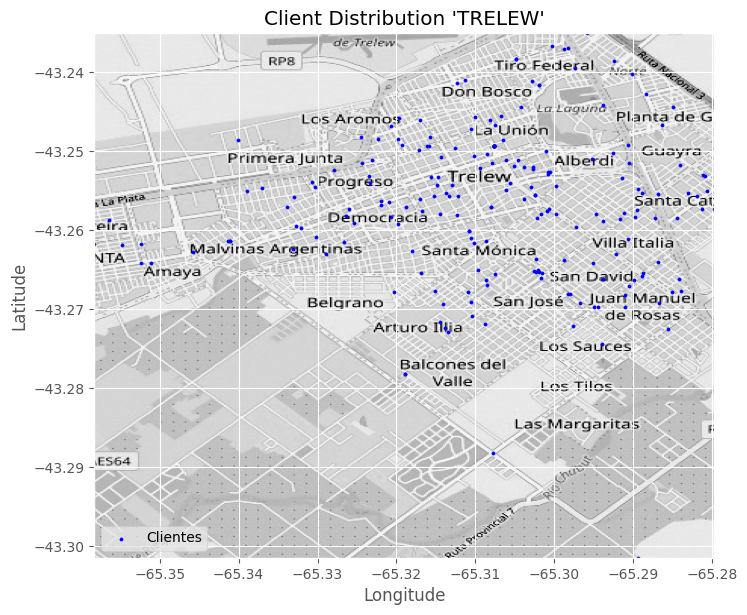

In [320]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(X[:,1], X[:,0], zorder=1, alpha= 1, c='b', s=5, label='Clientes')
ax.set_title('Client Distribution ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')


In [321]:
n = 4
k_means = KMeans(n_clusters=n)
# k_means.fit(X[:,1],X[:,2])
k_means.fit(X)

KMeans(n_clusters=4)

In [322]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

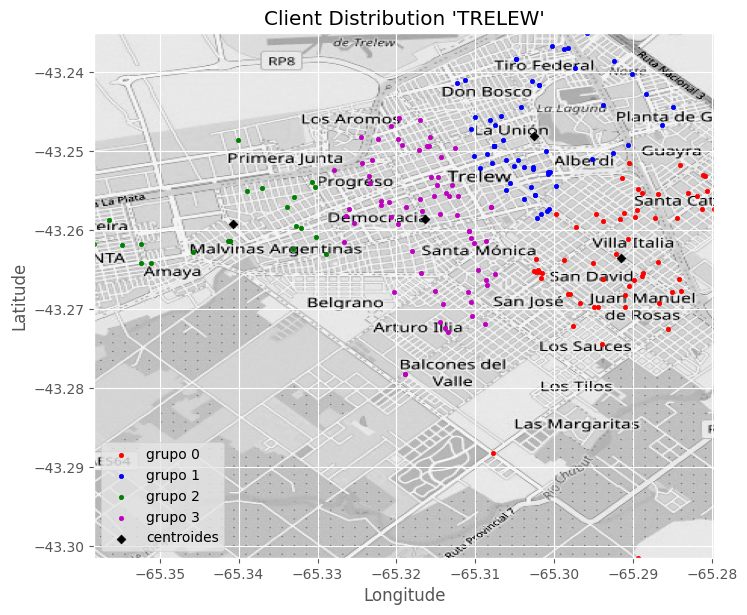

In [323]:
colors=['r','b','g','m', 'c', 'y']
fig, ax = plt.subplots(figsize = (8,7))
for i in range(0,n):
    ax.scatter(X[etiquetas==i,1],X[etiquetas==i,0],
               zorder=1, alpha= 1, c=f'{colors[i]}', s=10, label=f'grupo {i}')

ax.scatter(centroides[:,1],centroides[:,0],
           marker='D', zorder=1, alpha= 1, c='k', s=20, label='centroides')

ax.set_title('Client Distribution ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')

In [324]:
n = 4
for g in range(0,n):
    print(g, '=', len(X[etiquetas==g,0]))


0 = 56
1 = 61
2 = 22
3 = 65


In [325]:
wcss = [] 
for number_of_clusters in range(2, 11): 
    kmeans = KMeans(n_clusters = number_of_clusters)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
wcss

[0.03904647846367816,
 0.026931566665443853,
 0.019531888493558622,
 0.014961722455447394,
 0.012270156245315095,
 0.010353574026362734,
 0.008667573391043928,
 0.00747138762439198,
 0.00639811842995444]

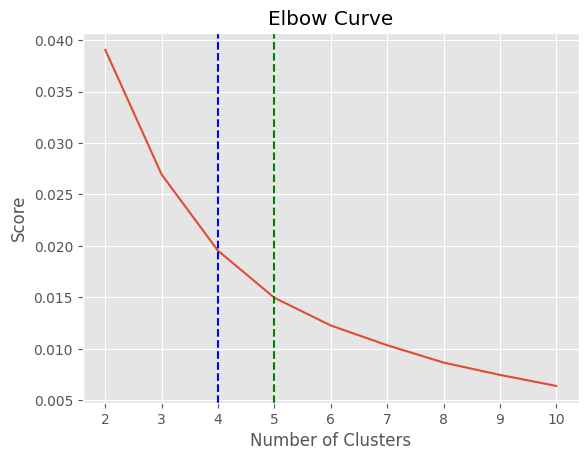

In [326]:
ks = range(2,11)
plt.plot(ks, wcss)
plt.axvline(4, linestyle='--', color='b')
plt.axvline(5, linestyle='--', color='g')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [327]:
n = 5
k_means = KMeans(n_clusters=n)
k_means.fit(X)

KMeans(n_clusters=5)

In [328]:
centroides = k_means.cluster_centers_
etiquetas = k_means.labels_

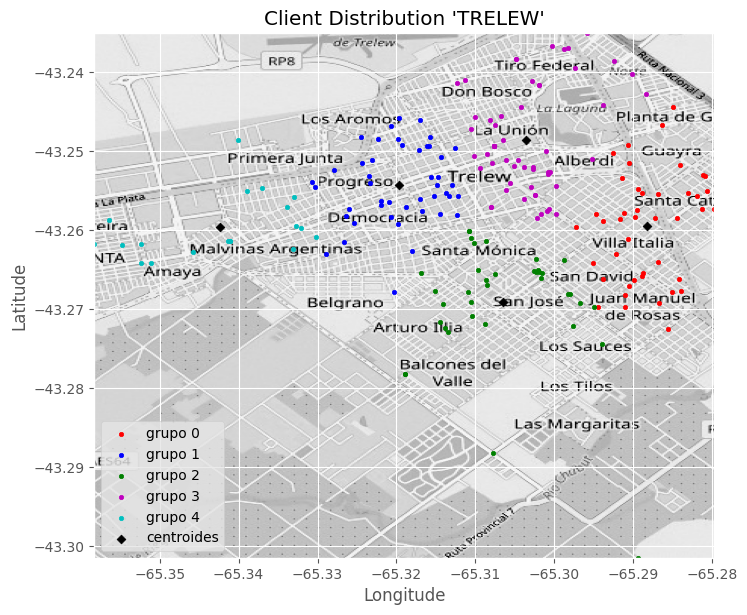

In [329]:
fig, ax = plt.subplots(figsize = (8,7))
for i in range(0,n):
    ax.scatter(X[etiquetas==i,1],X[etiquetas==i,0],
               zorder=1, alpha= 1, c=f'{colors[i]}', s=10, label=f'grupo {i}')

ax.scatter(centroides[:,1],centroides[:,0],
           marker='D', zorder=1, alpha= 1, c='k', s=20, label='centroides')

ax.set_title('Client Distribution ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')

In [330]:
n = 5
for g in range(0,n):
    print(g, '=', len(X[etiquetas==g,0]))

0 = 43
1 = 45
2 = 37
3 = 60
4 = 19


Y ahora los grupos de clientes según cada cluster

In [331]:
cli1 = clientes.loc[y[etiquetas==0]]
cli1.head()

,razon_social,domicilio,ciudad,cod_postal,provincia,url,coord,lat,long
cod_cliente,,,,,,,,,
020018,CLIENTE EJEMPLO 37,PASAJE LOS ANDES 1370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2578047, -65.29119659999999)",-43.257805,-65.291197
020057,CLIENTE EJEMPLO 76,TIERRA DEL FUEGO 370,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2662114, -65.2937891)",-43.266211,-65.293789
020078,CLIENTE EJEMPLO 97,MURGA 310,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.27246239999999, -65.2856333)",-43.272462,-65.285633
020082,CLIENTE EJEMPLO 101,PATAGONIA 314 UPCN,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2682272, -65.2910388)",-43.268227,-65.291039
020101,CLIENTE EJEMPLO 120,AV. EVA PERON 1401,TRELEW,9100,Chubut,https://maps.googleapis.com/maps/api/geocode/j...,"(-43.2554564, -65.2868373)",-43.255456,-65.286837


In [318]:
# la = np.array(cli1['lat'])
# lo = np.array(cli1['long'])
# cli1_a = np.column_stack((la,lo))
# cli1_a


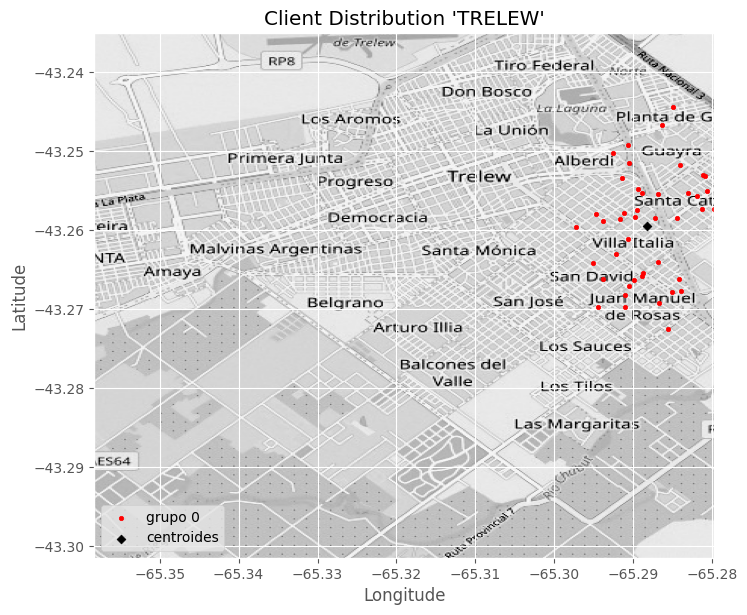

In [332]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(cli1.long, cli1.lat, zorder=1, alpha= 1, c=colors[0], s=10, label='grupo 0')

ax.scatter(centroides[0,1],centroides[0,0], marker='D', zorder=1, alpha= 1, c='k', s=20, label='centroides')

ax.set_title('Client Distribution ' + city)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='lower left')

ax.imshow(city_map, zorder=0, extent = bbox, aspect= 'equal')

Asignar en una nueva columna al dataframe original el numero de grupo de cliente a cada cliente